# RA model using the whole CV

In [90]:
#Import libraries
import tensorflow as tf
import tensorflowjs as tfjs
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Activation, Dense, LeakyReLU
from sklearn.model_selection import KFold
from sklearn import preprocessing

In [91]:
dataset = pd.ExcelFile('FSCAV_data_reduced.xlsx')
sheets = dataset.sheet_names # I need to have sheet names
dataset = pd.read_excel('FSCAV_data_reduced.xlsx', sheet_name = None, header = None) # extract data
ds = dataset[sheets[0]] #initialize DataSet

for i in range(1,len(sheets)-1):  #the last one is the 'Labels' one
    ds = pd.concat([ds, dataset[sheets[i]]],1)
CVs = np.transpose(ds.values)
labels = np.array(dataset[sheets[len(sheets)-1]].values[:,2])

In [92]:
#Normalization of features BUT NOT THE LABELS. 
#returns a numpy array
standard_scaler = preprocessing.StandardScaler()
CVs_scaled = standard_scaler.fit_transform(CVs)
dataset = np.zeros((len(labels), CVs_scaled.shape[1] + 1)) 
dataset[:,0:CVs_scaled.shape[1]] = CVs_scaled
dataset [:, CVs_scaled.shape[1]] = labels
dataset = pd.DataFrame(dataset)
dataset

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,-0.975647,-0.940276,-0.900009,-0.856493,-0.811219,-0.765444,-0.720155,-0.676075,-0.633697,-0.593330,...,0.218665,0.218988,0.219314,0.219641,0.219970,0.220297,0.220622,0.220944,0.221258,10.0
1,-0.777936,-0.747757,-0.713723,-0.677184,-0.639350,-0.601236,-0.563633,-0.527118,-0.492080,-0.458756,...,0.227237,0.227365,0.227503,0.227650,0.227807,0.227971,0.228140,0.228314,0.228491,10.0
2,-0.882376,-0.850981,-0.815105,-0.776237,-0.735723,-0.694705,-0.654077,-0.614500,-0.576426,-0.540139,...,0.262200,0.262302,0.262411,0.262526,0.262647,0.262772,0.262900,0.263031,0.263162,10.0
3,-1.129613,-1.098153,-1.060405,-1.018172,-0.973130,-0.926730,-0.880140,-0.834246,-0.789680,-0.746861,...,0.281504,0.281550,0.281605,0.281667,0.281736,0.281811,0.281892,0.281976,0.282062,10.0
4,-0.655781,-0.628651,-0.598410,-0.566215,-0.533092,-0.499897,-0.467287,-0.435740,-0.405569,-0.376963,...,0.298022,0.298110,0.298205,0.298305,0.298411,0.298520,0.298633,0.298748,0.298863,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6500,1.355680,1.372623,1.380305,1.380064,1.373395,1.361772,1.346543,1.328851,1.309634,1.289622,...,0.330931,0.331888,0.332841,0.333790,0.334732,0.335666,0.336587,0.337493,0.338375,100.0
6501,1.293262,1.314463,1.326593,1.330861,1.328656,1.321377,1.310306,1.296559,1.281049,1.264505,...,0.315486,0.316538,0.317586,0.318629,0.319663,0.320688,0.321699,0.322691,0.323658,100.0
6502,1.194725,1.216552,1.229989,1.236114,1.236182,1.231466,1.223143,1.212238,1.199600,1.185903,...,0.332650,0.333693,0.334732,0.335764,0.336789,0.337802,0.338801,0.339781,0.340736,100.0
6503,1.207028,1.228442,1.241410,1.247030,1.246574,1.241330,1.232489,1.221085,1.207971,1.193827,...,0.345292,0.346240,0.347184,0.348122,0.349053,0.349975,0.350885,0.351778,0.352648,100.0


In [93]:
#Define the model. Important: it needs to be the same structure as in tensorflow.js 
    
def build_and_compile_model():
    model = keras.Sequential([
    layers.Dense(1100, activation='relu', input_shape=[1100,]),
    layers.Dense(550, activation='selu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [94]:
#Define a function to plot the loss per epoch 
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Concentration]')
    plt.legend()
    plt.grid(True)
    plt.figure()
    plt.plot(history.history['root_mean_squared_error'], label="rmse")
    plt.plot(history.history['root_mean_squared_error'], label="rmse")
    plt.xlabel('Epoch')
    plt.ylabel('RMSE [Concentration]')

In [95]:
##Define a function to plot the prediction 
def plot_prediction(x, y):
    plt.scatter(train_features['Charge'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Charge')
    plt.ylabel('Concentration')
    plt.legend()

In [96]:
#Separate train and test, 80% and 20%. 
#train_dataset = dataset.sample(frac=0.80, random_state=0)
#test_dataset = dataset.drop(train_dataset.index)
#Separate labels from input
#train_features = train_dataset.copy()
#test_features = test_dataset.copy()
#train_labels = train_features.pop(1100)
#test_labels = test_features.pop(1100)

In [97]:
#Shuffling the whole dataset. 
dataset = dataset.sample(frac=1).reset_index(drop=True)


RMSE: 
3.887620384319016
RMSE: 
34.9032772756828
RMSE: 
4.093377503746068
RMSE: 
3.7626410257470515
RMSE: 
3.9080895337784898


<Figure size 432x288 with 0 Axes>

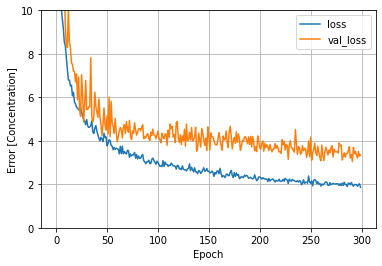

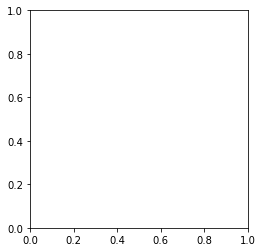

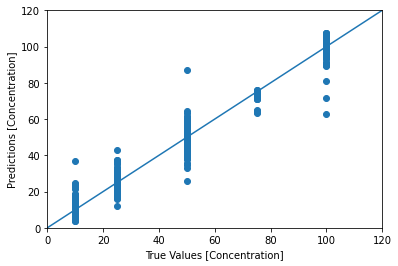

<Figure size 432x288 with 0 Axes>

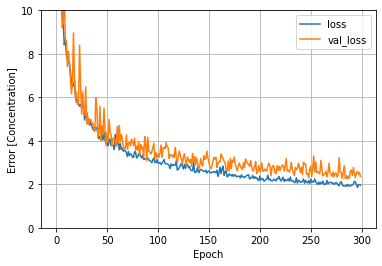

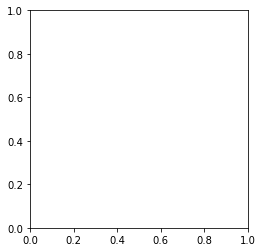

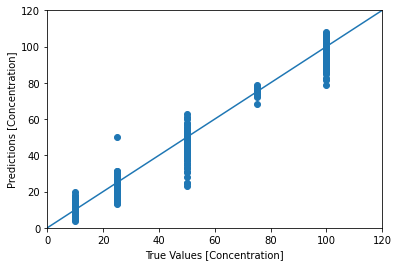

<Figure size 432x288 with 0 Axes>

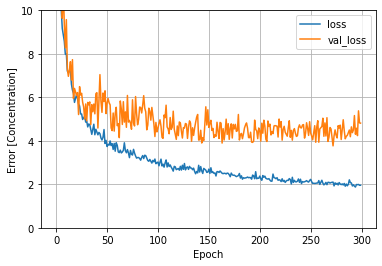

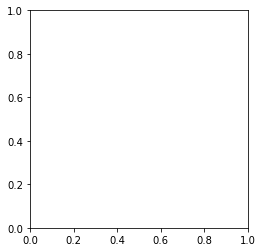

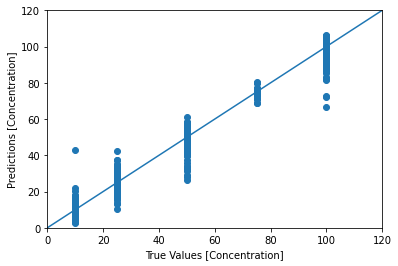

<Figure size 432x288 with 0 Axes>

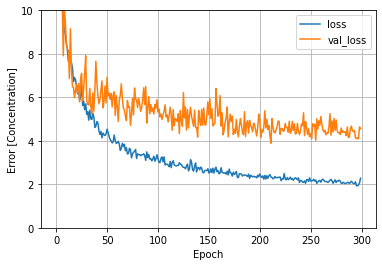

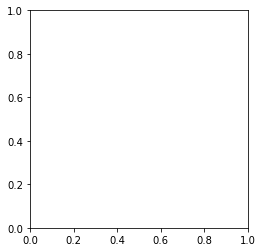

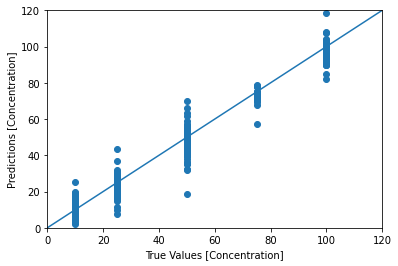

<Figure size 432x288 with 0 Axes>

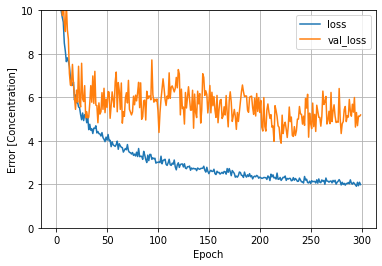

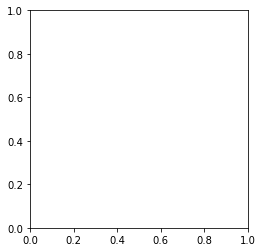

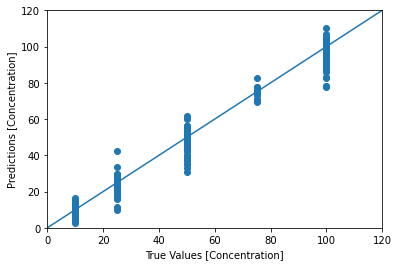

In [98]:
inputs = dataset.copy()
targets = np.array(inputs.pop(1100).values)
inputs = np.array(inputs.values)
# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    dnn_fscav = build_and_compile_model()
    #dnn_fscav.summary()
    #Train the model
    history = dnn_fscav.fit(
    inputs[train], targets[train],                         # changed expression for test features and labels
    validation_split=0.25,                                 # I removed validation for k-fold cross validation
    verbose=0, epochs=300)
    newfig = plt.figure()
    plot_loss(history)
    #Prediction of the validation dataset 
    test_predictions = dnn_fscav.predict(inputs[test]).flatten()

    a = plt.axes(aspect='equal')
    newfig2 = plt.figure()
    plt.scatter(targets[test], test_predictions)
    plt.xlabel('True Values [Concentration]')
    plt.ylabel('Predictions [Concentration]')
    lims = [0, 120]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    print('RMSE: ')
    print(math.sqrt(tf.keras.losses.MSE(test_predictions, targets[test])))
    fold_no = fold_no + 1

## Tensorflow.js export



In [99]:
##Exporting model to JS. 
dnn_fscav.save('Model')
##Save the model to be loaded into tensorflow.js
tfjs.converters.save_keras_model(dnn_fscav, 'Model_js')


INFO:tensorflow:Assets written to: Model\assets


In [100]:
#Export means and variance of features to transform data in web app. 
import json
mean_text = json.dumps(standard_scaler.mean_.tolist())
var_text = json.dumps(standard_scaler.var_.tolist())
std_text = json.dumps(standard_scaler.scale_.tolist())

In [101]:
mean_text

'[0.4494069717034065, 0.44263817643513936, 0.43458201430217563, 0.42522514994799504, 0.4145519445365666, 0.4025503986189919, 0.38921230763114006, 0.3745334077347507, 0.35851353644640366, 0.3411567332176465, 0.32247139529054886, 0.3024703460894229, 0.2811709526469699, 0.2585951846446525, 0.23476967071892355, 0.20972577356034564, 0.18349958548787082, 0.15613194398989994, 0.127668458302321, 0.09815942514257828, 0.06765988761715601, 0.03622947705541913, 0.003932400477909311, -0.02916264713966174, -0.06298262518157093, -0.09745025129669534, -0.1324841337085468, -0.16799889210581134, -0.20390541669306697, -0.24011097640022322, -0.27651944244459653, -0.3130314855790915, -0.3495448215781858, -0.3859544328707718, -0.422152807358555, -0.45803019814588114, -0.49347489650541226, -0.5283735291932509, -0.5626112139535276, -0.5960720801734046, -0.6286392406911262, -0.6601954063913462, -0.6906229235048635, -0.719804258017587, -0.7476221364727168, -0.773959956581663, -0.7987019981991234, -0.82173379502

In [102]:
std_text

'[0.4863360825813458, 0.5122608830963485, 0.5424813922370828, 0.5769942243810944, 0.6157501200523775, 0.6586657873440392, 0.7056378765449302, 0.7565530387000029, 0.8112957394108149, 0.8697525785396906, 0.9318152810438481, 0.9973813785208191, 1.0663546708040872, 1.138644623376552, 1.2141653804291426, 1.2928352288968816, 1.3745754025469217, 1.4593088324123695, 1.5469603962664236, 1.6374535837550497, 1.7307141648229794, 1.8266656581012197, 1.925229401994871, 2.026327233553321, 2.129878043119197, 2.235797258190302, 2.343998861379394, 2.4543961657484274, 2.566897301295636, 2.6814083220721, 2.797833103260172, 2.916073205223295, 3.0360278499945514, 3.1575927181011925, 3.2806621273119094, 3.4051290547683677, 3.5308840187333863, 3.657813919062074, 3.7858088279895634, 3.914750752273209, 4.044528309920161, 4.1750233059463575, 4.306120829037045, 4.437702653201815, 4.569652854688354, 4.701854520307554, 4.83419320127527, 4.966551356592898, 5.098816297382488, 5.230875746175312, 5.362616835279089, 5.4

In [103]:
var_text

'[0.23652278522056963, 0.2624112123506509, 0.29428606092348364, 0.33292233496914064, 0.3791482103445173, 0.4338406194175431, 0.497924812814838, 0.572372500366208, 0.6582007767861409, 0.7564695478764406, 0.8682797179868257, 0.9947696142200895, 1.1371122839456933, 1.29651157834433, 1.4741975710326445, 1.6714229290768525, 1.8894575372870315, 2.129582268356753, 2.3930864676167705, 2.6812542389522553, 2.995371520318903, 3.336707426486362, 3.7065082503055287, 4.106002057439854, 4.536380478561259, 4.998789379731271, 5.494330662147895, 6.024060538440582, 6.588961755398819, 7.189950589677514, 7.827870073698446, 8.503482938221262, 9.217465105942537, 9.970391773405677, 10.762743993578702, 11.594903879627717, 12.467141953746827, 13.379602666484248, 14.332348482083713, 15.325273452423653, 16.358209249745638, 17.430819605195254, 18.54267659426669, 19.693204838234433, 20.881727212361422, 22.10743593013658, 23.369423907256046, 24.666632377674755, 25.997927634453262, 27.36206107192513, 28.7576593220187